# Product Demand Forecasting using ARIMA

## Dataset
The [dataset](https://www.kaggle.com/datasets/felixzhao/productdemandforecasting/) contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. 

If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

## Importing Necessary Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('Historical Product Demand.csv')
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


## Explore the Dataset

In [3]:
df.Warehouse.unique()

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [4]:
len(df.Product_Category.unique())

33

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Check the number of data with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

# Check the number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))

11239  /  1048575
1  /  5


In [8]:
#Lets check where these nulls are.
print (df.isna().sum())

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


The detaset has 11239 NAN, that all of them are in just Date column.

In [9]:
# Remove all rows with NAs.
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1037331,Product_1791,Whse_J,Category_006,2016-04-27,1000
1037332,Product_1974,Whse_J,Category_006,2016-04-27,1
1037333,Product_1787,Whse_J,Category_006,2016-04-28,2500
1037334,Product_0901,Whse_J,Category_023,2016-10-07,50


In [10]:
df.sort_values('Date')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
...,...,...,...,...,...
1009604,Product_1710,Whse_J,Category_026,2017-01-06,15
921328,Product_1359,Whse_J,Category_019,2017-01-06,100000
908447,Product_0250,Whse_C,Category_007,2017-01-09,148
863020,Product_1904,Whse_C,Category_019,2017-01-09,4000


Some of the Order_Demand values have () in them.

In [11]:
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"", regex=False)
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"", regex=False)

# Change the data type of Order_Demand from object to integer.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [12]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

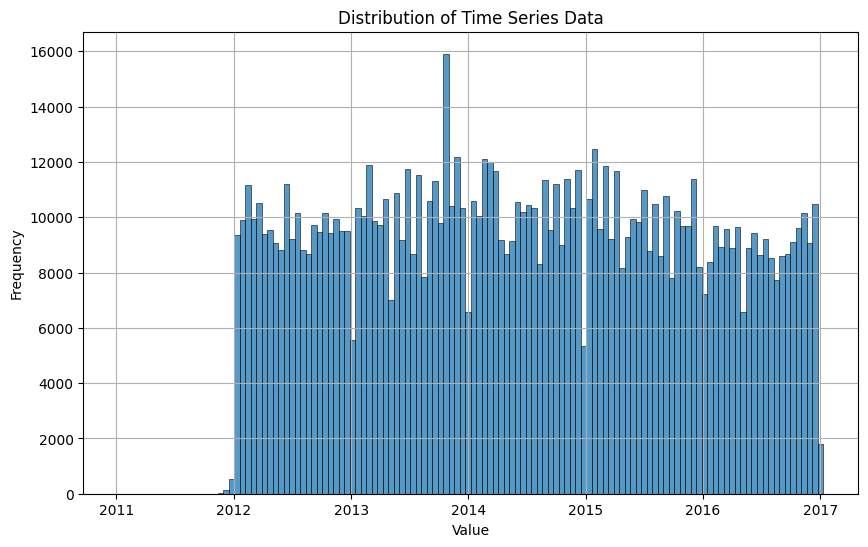

In [13]:
# Time distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Date'])
plt.title('Distribution of Time Series Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Since the dates before 2012 and after 2017 have a lot of missing values, we will start with data from January 2012 until December 2016.

In [14]:
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

In [15]:
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2
196928,Product_0614,Whse_S,Category_001,2012-01-02,3
200087,Product_1281,Whse_S,Category_019,2012-01-02,14000
200086,Product_1355,Whse_S,Category_019,2012-01-02,5000
77313,Product_2169,Whse_S,Category_024,2012-01-02,55
...,...,...,...,...,...
995585,Product_0200,Whse_A,Category_007,2016-12-30,20
981262,Product_1388,Whse_A,Category_019,2016-12-30,100
999913,Product_1341,Whse_S,Category_019,2016-12-30,15000
981263,Product_1513,Whse_A,Category_019,2016-12-30,100


In [16]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [17]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum(numeric_only=True).sort_values('Order_Demand', ascending = False)

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders.

33


<Axes: xlabel='Product_Category', ylabel='count'>

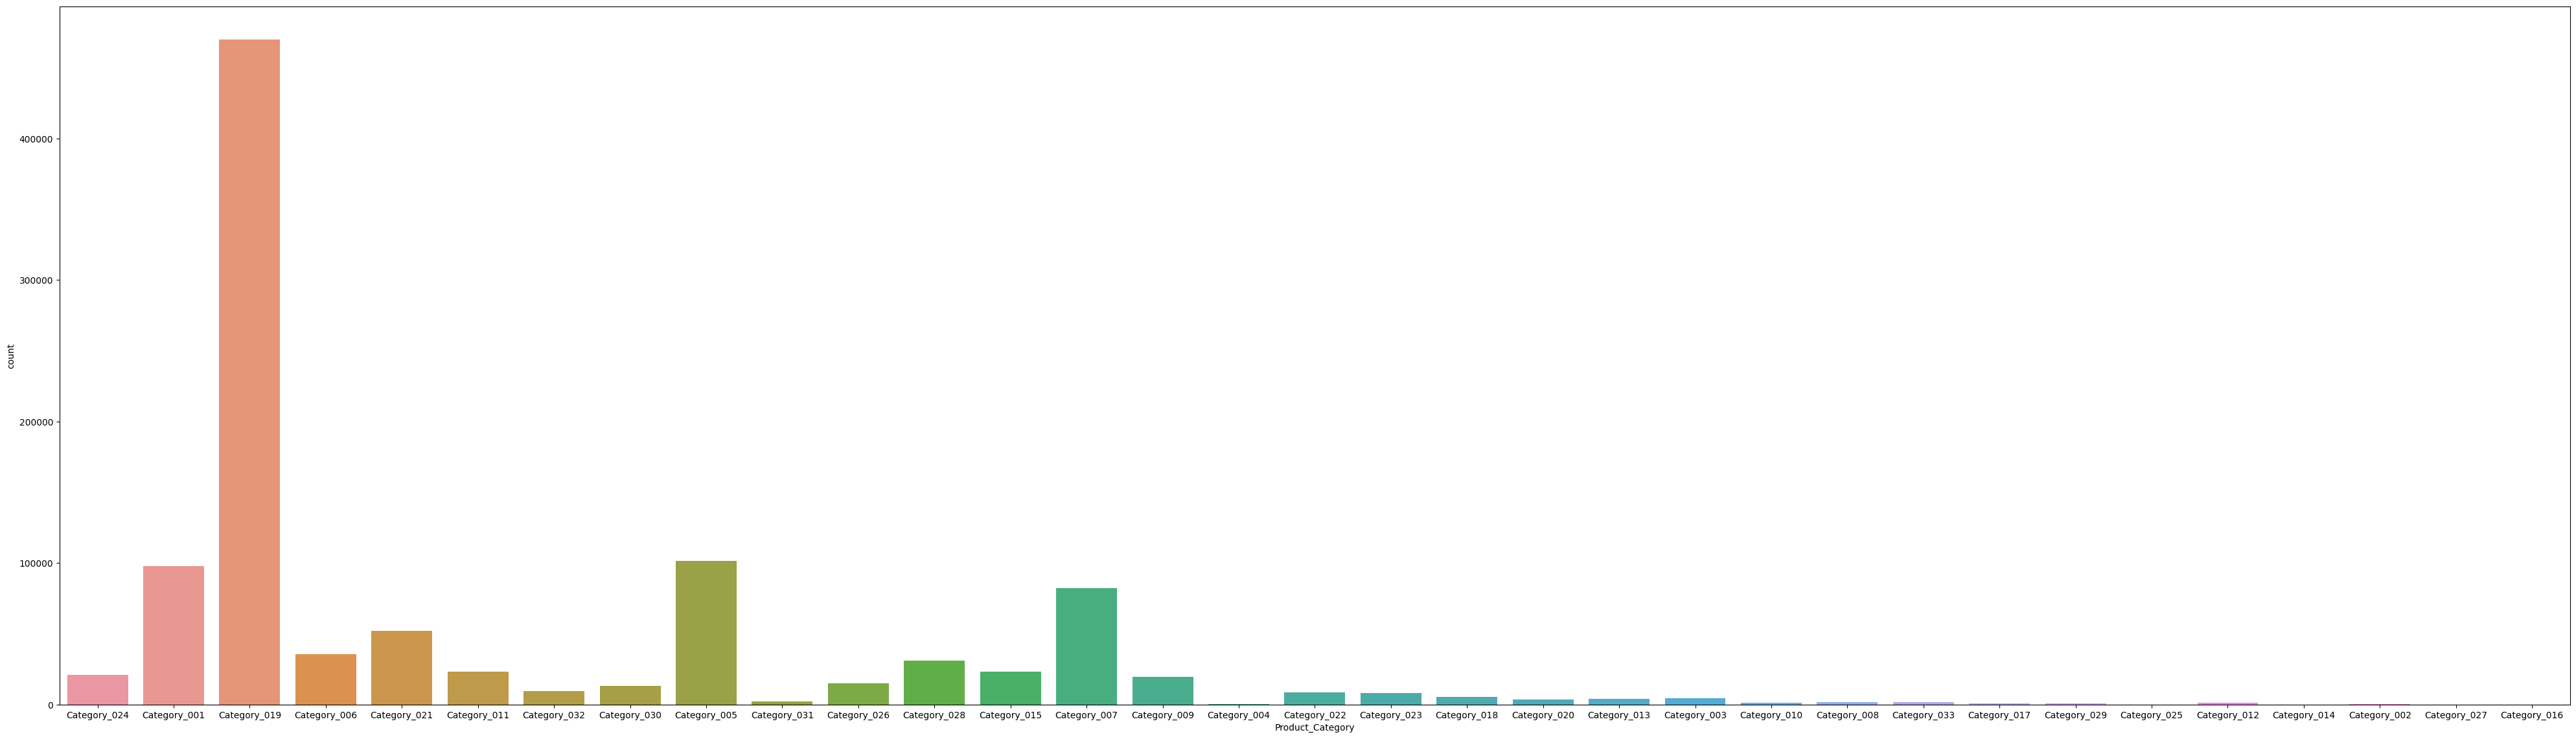

In [18]:
# Product Category
from matplotlib import rcParams
print(len(df['Product_Category'].value_counts()))

rcParams['figure.figsize'] = 50,14
sns.countplot(data=df, x='Product_Category')

There seems to be a lot of orders in category 19.

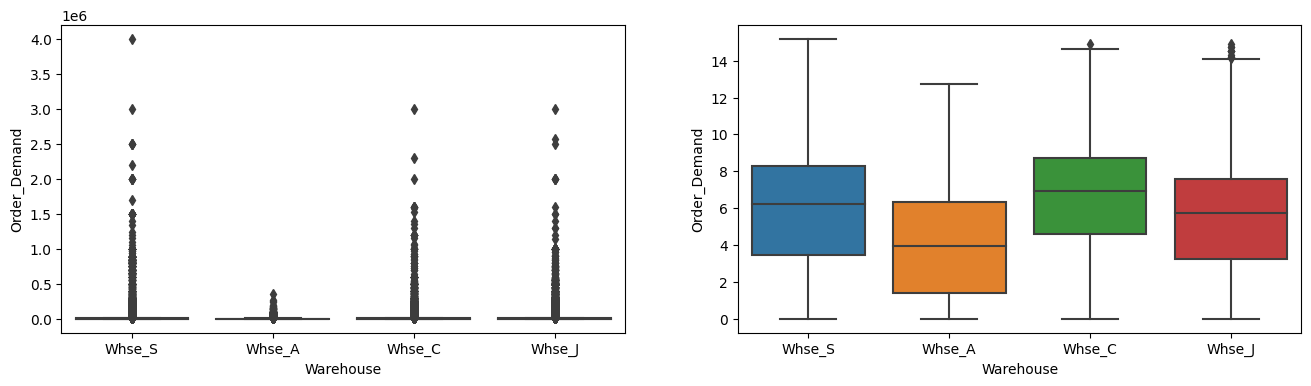

In [19]:
# Check the orders by warehouse

rcParams['figure.figsize'] = 16,4

fig, ax = plt.subplots(1, 2)

# Regular Data
fig1 = sns.boxplot(x='Warehouse', y='Order_Demand', data=df, ax=ax[0])

# Data with Log Transformation
fig2 = sns.boxplot(x='Warehouse', y=np.log1p(df['Order_Demand']), data=df, ax=ax[1])

plt.show()

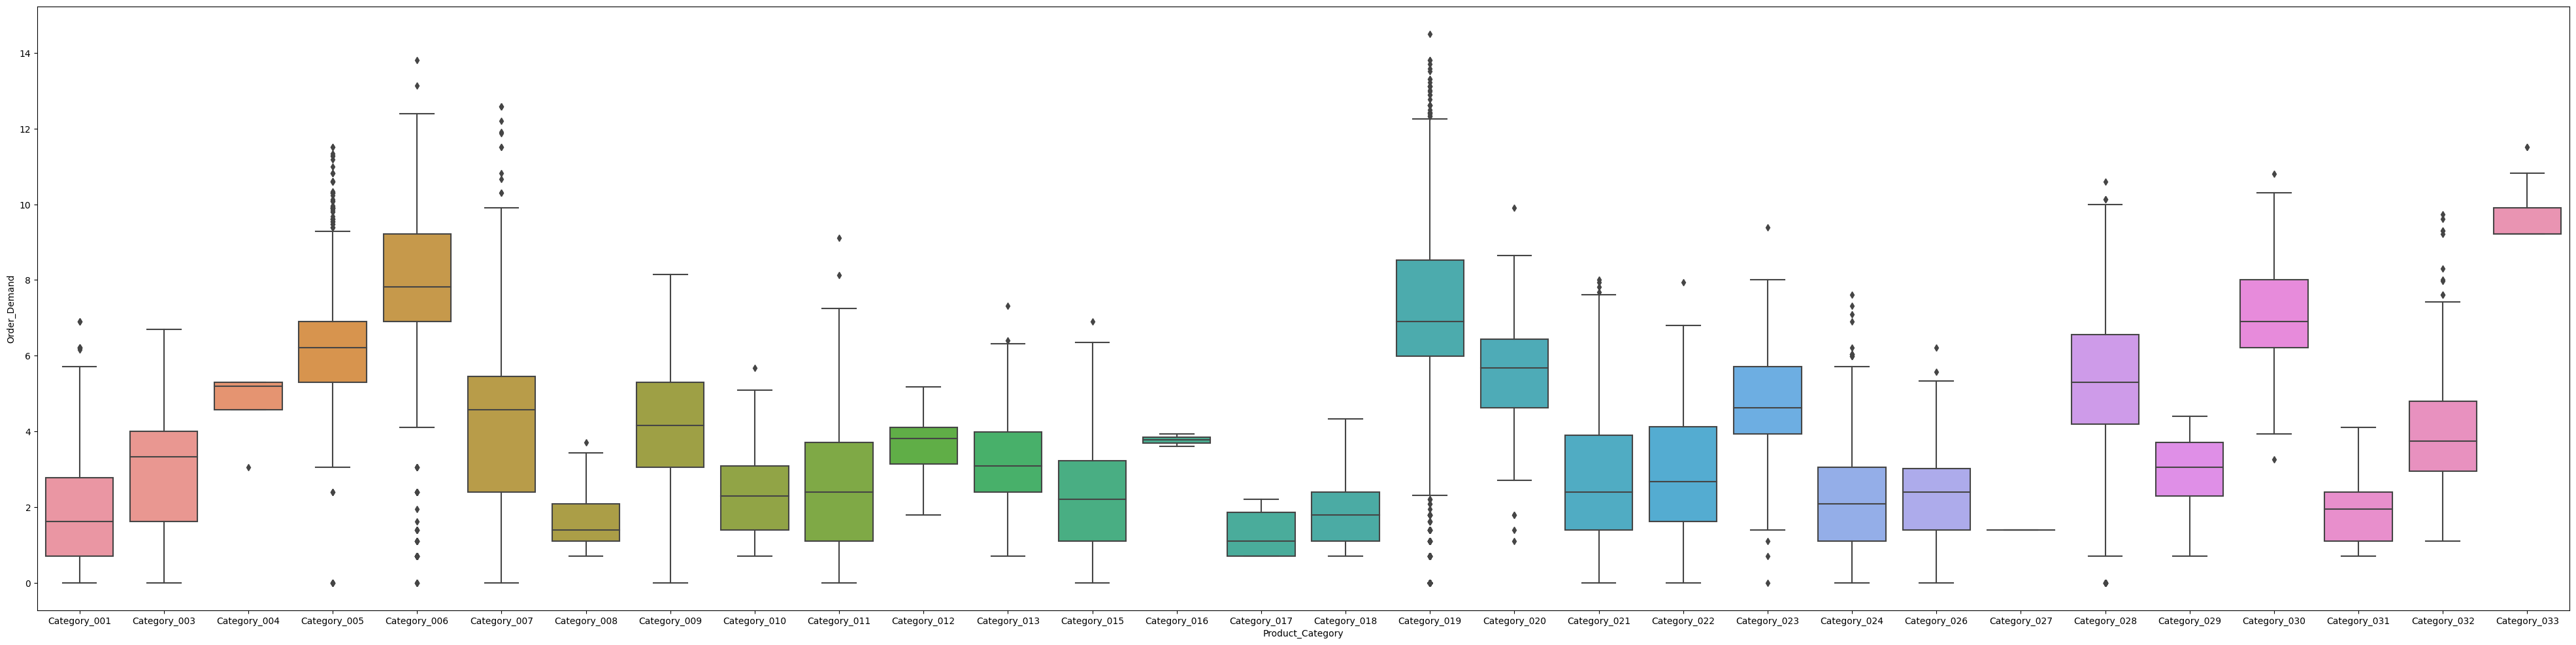

In [20]:
# Lets check the Orders by Product Category

rcParams['figure.figsize'] = 50,12

#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()

fig3 = sns.boxplot(x=df_temp['Product_Category'].sort_values(), y=np.log1p(df_temp['Order_Demand']))

plt.show()

### Exploring the Data as TIME SERIES

In [21]:
# total orders placed on each day

df = df.groupby('Date')['Order_Demand'].sum().reset_index()

In [22]:
#Index the date
df = df.set_index('Date')

In [23]:
df

,Order_Demand
Date,
2012-01-01,2
2012-01-02,680277
2012-01-03,1645257
2012-01-04,1295861
2012-01-05,8941774
...,...
2016-12-26,3628370
2016-12-27,1674226
2016-12-28,2740302


In [24]:
#Averages daily sales value for the month, and we are using the start of each month as the timestamp.
y = df['Order_Demand'].resample('MS').mean()

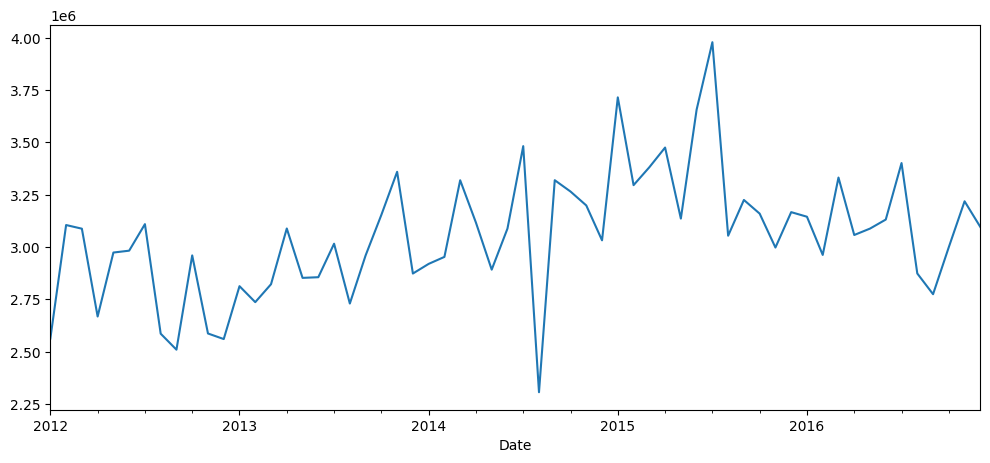

In [25]:
#Visualizing time series.

y.plot(figsize=(12,5))
plt.show()

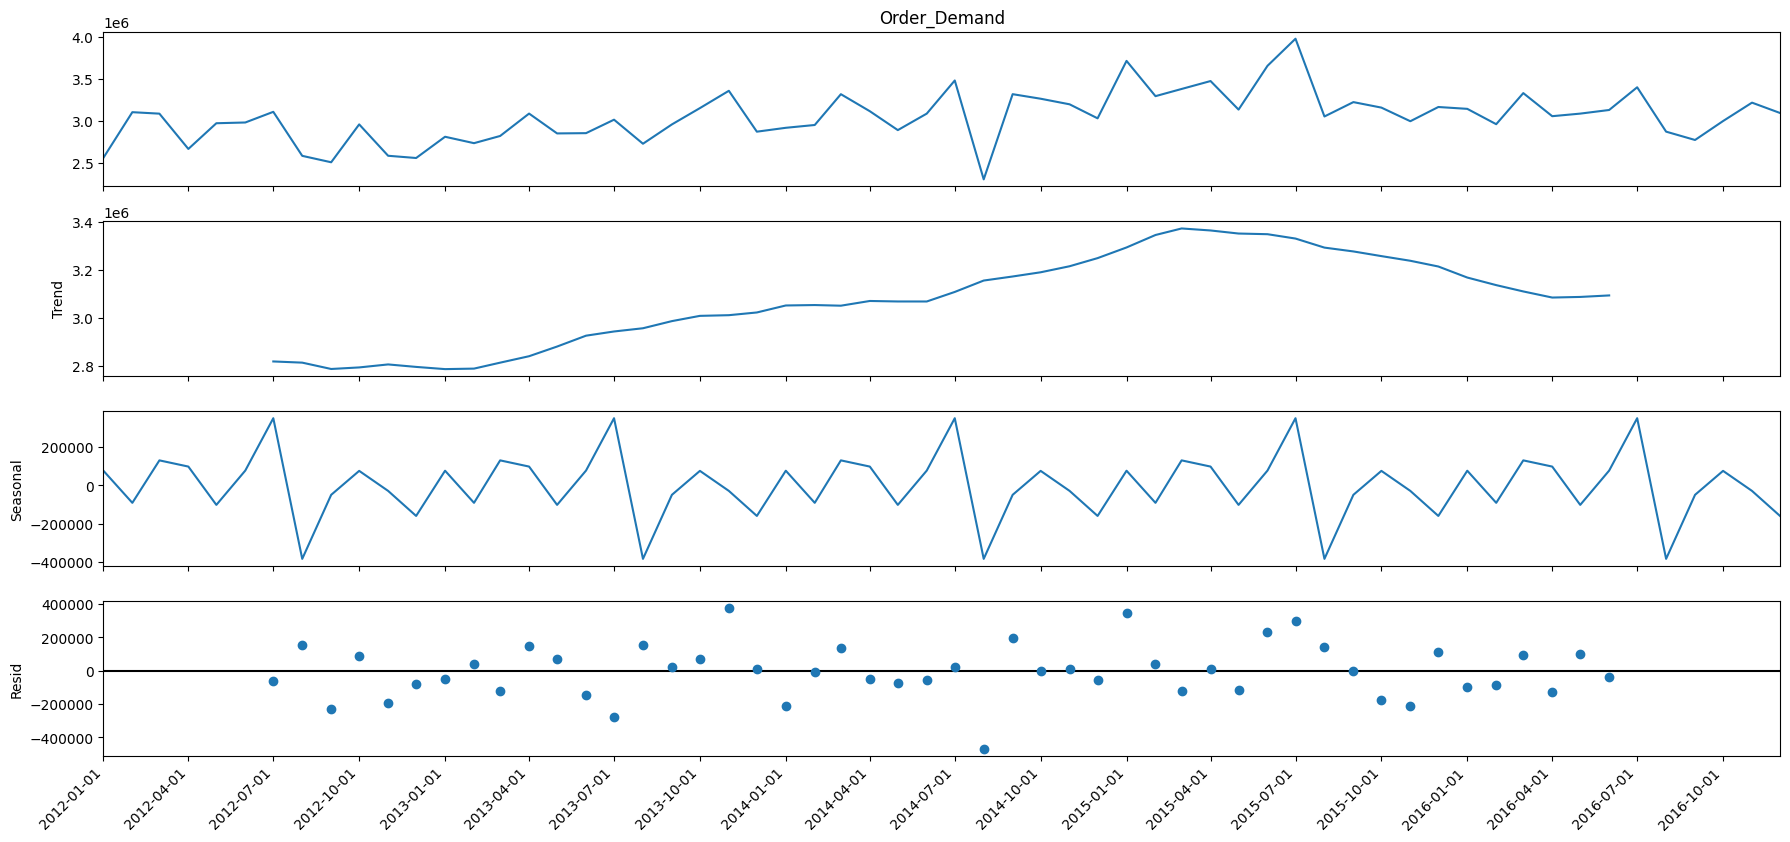

In [26]:
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')

fig = decomposition.plot()
plt.xticks(rotation=45, ha='right')
plt.xticks(decomposition.trend.index[::3])

plt.show()

## ARIMA MODEL

ARIMA stands for AutoRegressive Integrated Moving Average. It is a popular time series forecasting model that combines autoregression, differencing, and moving average components to make predictions about future points in a time series.

The general notation for an ARIMA model is ARIMA(p, d, q), where:

* p: Order of the autoregressive part.
* d: Degree of differencing.
* q: Order of the moving average part.

SARIMA (Seasonal ARIMA) is a variation of ARIMA that extends ARIMA to handle seasonality in time series data.

### Grid Search
Grid search is a technique used in machine learning and statistical modeling to find the optimal hyperparameters for a model.

In the context of ARIMA models, we use grid search to find the optimal values for the hyperparameters p, d, and q in ARIMA(p, d, q)

In [27]:
#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.927583212436
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3176.8067530713106
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859485
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3046.0346837059465
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.087487804522
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700705
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345484
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3092.2399207853928
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.1005721650909
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277784
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759123
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2990.39842781236
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC

The AIC quantifies the trade-off between the goodness of fit of a model and the simplicity of the model (in terms of the number of parameters). The idea is to choose a model that fits the data well but does not have an excessive number of parameters, to avoid overfitting.

* Large AIC: Model fits very well using a lot of features.
* Small AIC: Model fits similar fit but using lesser features. 

The lower AIC is the better than the higher.

In [29]:
#Fit the model with the best params:
# SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.5164122018642

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


Model Parameters:

1. AR.L1 (AutoRegressive Lag 1): The coefficient is -0.2450, indicating the strength and direction of the relationship between the observation and its lagged value at a lag of 1.

2. MA.L1 (Moving Average Lag 1): The coefficient is -0.4385, indicating the strength and direction of the relationship between the observation and its lagged forecast errors at a lag of 1.

3. AR.S.L12 (Seasonal AutoRegressive Lag 12): The coefficient is -0.4568, indicating the strength and direction of the relationship between the observation and its value at the same season in the previous year.

4. Statistical Significance:
For each coefficient, the associated p-value is provided (P>|z|). If the p-value is less than a chosen significance level (commonly 0.05), the null hypothesis that the coefficient is zero is rejected, suggesting the parameter is statistically significant.
In this output, the AR.S.L12 coefficient has a p-value of 0.028, which is less than 0.05, indicating statistical significance.

5. Standard Errors and Confidence Intervals:
The standard errors (std err) measure the variability of the estimated coefficients. Lower standard errors generally indicate more precise estimates.
The 95% confidence intervals for each coefficient are provided in the [0.025, 0.975] columns.

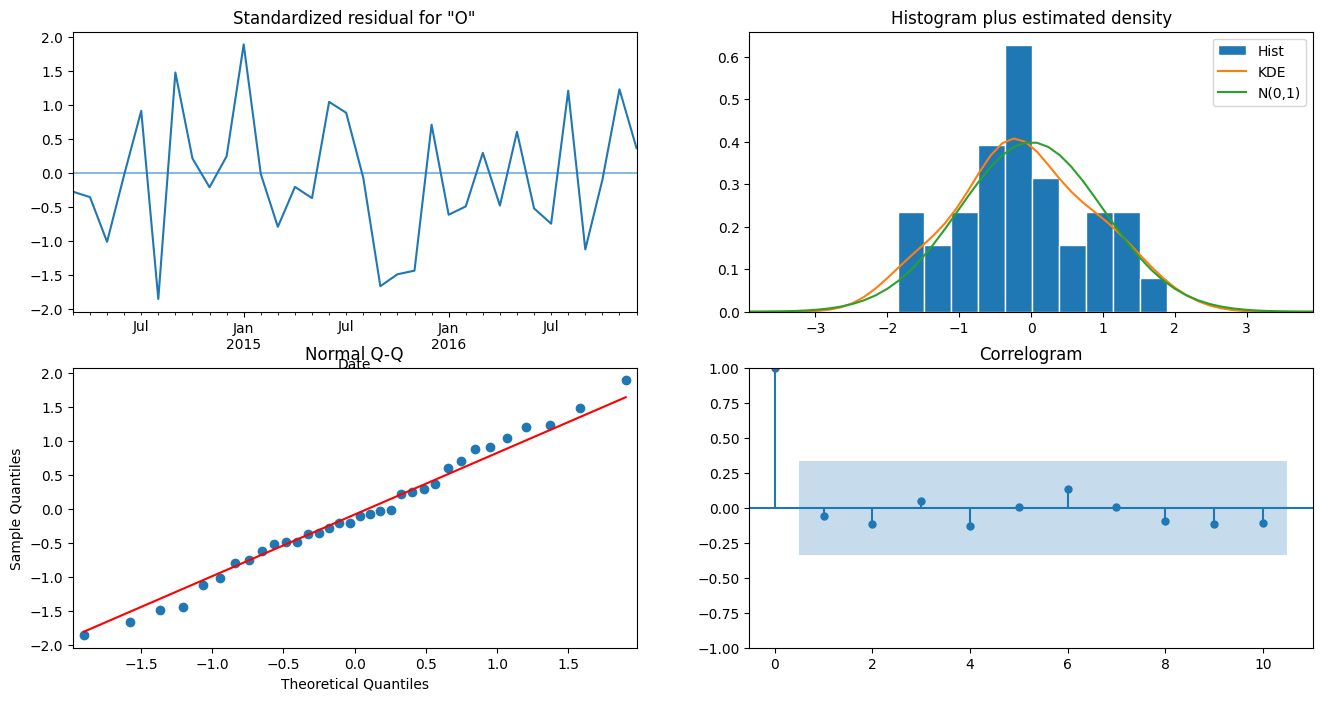

In [30]:
#Plotting the diagnostics.
#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

results.plot_diagnostics(figsize=(16, 8))
plt.show()

What to look for?

1. Residuals SHOULD be Normally Distributed ; Check
* Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation for normal distribution with mean 0 and sd 1.
* Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). 

2. Residuals are not correlated; Check
* Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
* Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with its own lagged versions.

### Model Validation

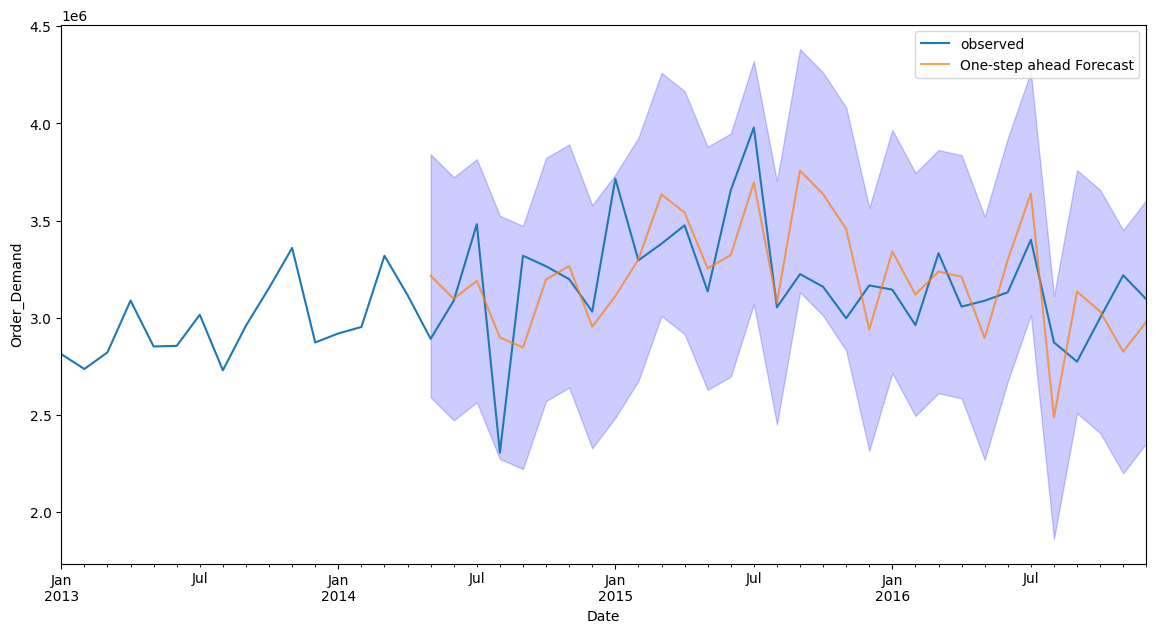

In [31]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False) #false is when using the entire history.

#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 


### Forecast Accuracy

In [32]:
#Getting the mean squared error (average error of forecasts)

y_forecasted = pred.predicted_mean

y_truth = y['2016-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()

print('MSE {}'.format(round(mse, 2)))

MSE 55459437833.69


In [33]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 235498.28


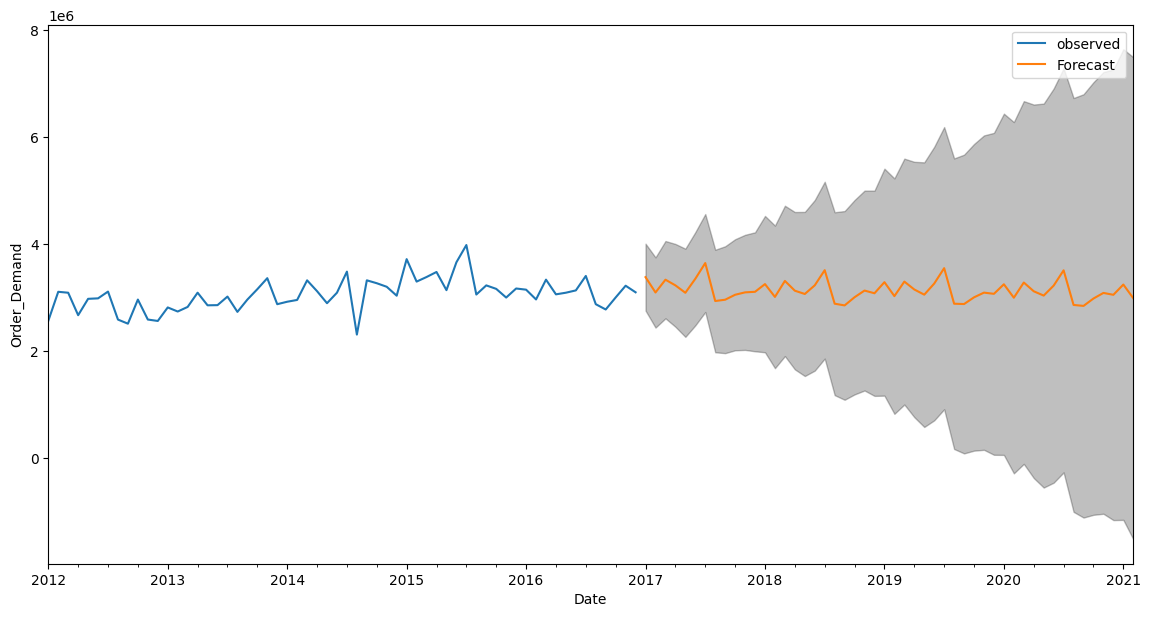

In [34]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.